# Homework
---

### Dataset

In this homework, we'll build a model for predicting if we have an image of a dog or a cat. For this,
we will use the "Dogs & Cats" dataset that can be downloaded from [Kaggle](https://www.kaggle.com/c/dogs-vs-cats/data). 

You need to download the `train.zip` file.

If you have troubles downloading from Kaggle, use [this link](https://github.com/alexeygrigorev/large-datasets/releases/download/dogs-cats/train.zip) instead:

```bash
wget https://github.com/alexeygrigorev/large-datasets/releases/download/dogs-cats/train.zip
```

In the lectures we saw how to use a pre-trained neural network. In the homework, we'll train a much smaller model from scratch. 

**Note:** You don't need a computer with a GPU for this homework. A laptop or any personal computer should be sufficient. 

### Data Preparation

The dataset contains 12,500 images of cats and 12,500 images of dogs. 

Now we need to split this data into train and validation

* Create a `train` and `validation` folders
* In each folder, create `cats` and `dogs` folders
* Move the first 10,000 images to the train folder (from 0 to 9999) for boths cats and dogs - and put them in respective folders
* Move the remaining 2,500 images to the validation folder (from 10000 to 12499)

You can do this manually or with Python (check `os` and `shutil` packages).

### Model

For this homework we will use Convolutional Neural Network (CNN. Like in the lectures, we'll use Keras.

You need to develop the model with following structure:

* The shape for input should be `(150, 150, 3)`
* Next, create a covolutional layer ([`Conv2D`](https://keras.io/api/layers/convolution_layers/convolution2d/)):
    * Use 32 filters
    * Kernel size should be `(3, 3)` (that's the size of the filter)
    * Use `'relu'` as activation 
* Reduce the size of the feature map with max pooling ([`MaxPooling2D`](https://keras.io/api/layers/pooling_layers/max_pooling2d/))
    * Set the pooling size to `(2, 2)`
* Turn the multi-dimensional result into vectors using a [`Flatten`](https://keras.io/api/layers/reshaping_layers/flatten/) layer
* Next, add a `Dense` layer with 64 neurons and `'relu'` activation
* Finally, create the `Dense` layer with 1 neuron - this will be the output
    * The output layer should have an activation - use the appropriate activation for the binary classification case

As optimizer use [`SGD`](https://keras.io/api/optimizers/sgd/) with the following parameters:

* `SGD(lr=0.002, momentum=0.8)`


For clarification about kernel size and max pooling, check [Week #11 Office Hours](https://www.youtube.com/watch?v=1WRgdBTUaAc).

In [1]:
import os
import shutil
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.applications.xception import preprocess_input
#from tensorflow.keras.applications.xception import Xception
#from tensorflow.keras.layers import Conv2D
#from tensorflow.keras.layers import MaxPooling2D
#from tensorflow.keras.layers import Flatten
#from tensorflow.keras.layers import Dense
#from tensorflow.keras.layers import ReLU

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
## Download and unzip Dataset
data = 'https://github.com/alexeygrigorev/large-datasets/releases/download/dogs-cats/train.zip'
if not os.path.exists("train.zip"):
    print("[INFO] Downloading Dataset")
    !wget $data
    shutil.unpack_archive("train.zip", "dataset")
else:
    print("[INFO] Dataset already downloaded")

[INFO] Dataset already downloaded


In [3]:
# Prepare Dataset

## from imutils ---> https://github.com/PyImageSearch/imutils/blob/master/imutils/paths.py
def list_files(basePath, validExts=None, contains=None):
    # loop over the directory structure
    for (rootDir, dirNames, filenames) in os.walk(basePath):
        # loop over the filenames in the current directory
        for filename in filenames:
            # if the contains string is not none and the filename does not contain
            # the supplied string, then ignore the file
            if contains is not None and filename.find(contains) == -1:
                continue

            # determine the file extension of the current file
            ext = filename[filename.rfind("."):].lower()

            # check to see if the file is an image and should be processed
            if validExts is None or ext.endswith(validExts):
                # construct the path to the image and yield it
                imagePath = os.path.join(rootDir, filename)
                yield imagePath


def dataset_split(input_folder="dataset/train", output_folder="dataset/validation", thr=10000.0):
    train_dog_folder = os.path.join(input_folder, "dog")
    train_cat_folder = os.path.join(input_folder, "cat")
    validation_dog_folder = os.path.join(output_folder, "dog")
    validation_cat_folder = os.path.join(output_folder, "cat")
    
    if not os.path.exists(validation_dog_folder):
        os.makedirs(validation_dog_folder)
    if not os.path.exists(validation_cat_folder):
        os.makedirs(validation_cat_folder)
    if not os.path.exists(train_dog_folder):
        os.makedirs(train_dog_folder)
    if not os.path.exists(train_cat_folder):
        os.makedirs(train_cat_folder)
        
    for file in list_files(input_folder, validExts=(".jpg")):
        label = os.path.split(file)[-1].split(".")[0]
        n_id = float(os.path.split(file)[-1].split(".")[1])
        if n_id >= thr:
            if label == "dog":
                print(f"[INFO] Moving {file} to {validation_dog_folder} folder")
                shutil.move(file, validation_dog_folder)
            else:
                print(f"[INFO] Moving {file} to {validation_cat_folder} folder")
                shutil.move(file, validation_cat_folder)
        else:
            if label == "dog":
                print(f"[INFO] Moving {file} to {train_dog_folder} folder")
                shutil.move(file, train_dog_folder)
            else:
                print(f"[INFO] Moving {file} to {train_cat_folder} folder")
                shutil.move(file, train_cat_folder)

    

In [4]:
#dataset_split()

In [5]:
def make_model(learning_rate=0.002):
    #base_model = Xception(
    #    weights='imagenet',
    #    include_top=False,
    #    input_shape=(150, 150, 3)
    #)

    #base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(150, 150, 3))
    #base = base_model(inputs, training=False)
    #vectors = keras.layers.GlobalAveragePooling2D()(base)

    conv_2d = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(inputs)
    reduced = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_2d)
    vectors = keras.layers.Flatten()(reduced)
    dense_64 = keras.layers.Dense(64, activation='relu')(vectors)
    outputs = keras.layers.Dense(1, activation='sigmoid')(dense_64)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.8)
    loss = keras.losses.BinaryCrossentropy(from_logits=False)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model


In [6]:
model = make_model()

2021-11-21 22:51:15.975484: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-21 22:51:15.984798: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-21 22:51:15.985347: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-21 22:51:15.986350: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

### Question 1

Since we have a binary classification problem, what is the best loss function for us?

Note: since we specify an activation for the output layer, we don't need to set `from_logits=True`

In [7]:
print("[ANSWER-1] For a binary classification problem the besst loss funtion is : BinaryCrossentropy")

[ANSWER-1] For a binary classification problem the besst loss funtion is : BinaryCrossentropy


### Question 2

What's the total number of parameters of the model? You can use the `summary` method for that. 


In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 175232)            0         
                                                                 
 dense (Dense)               (None, 64)                11214912  
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                             

In [9]:
print("[ANSWER-2] The total number of parameters is: 11,215,873")

[ANSWER-2] The total number of parameters is: 11,215,873


### Generators and Training

For the next two questions, use the following data generator for both train and validation:

```python
ImageDataGenerator(rescale=1./255)
```

* We don't need to do any additional pre-processing for the images.
* When reading the data from train/val directories, check the `class_mode` parameter. Which value should it be for a binary classification problem?
* Use `batch_size=20`
* Use `shuffle=True` for both training and validaition 

For training use `.fit()` with the following params:

```python
model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=50
)
```

Note `validation_steps=50` - this parameter says "run only 50 steps on the validation data for evaluating the results". 
This way we iterate a bit faster, but don't use the entire validation dataset.
That's why it's important to shuffle the validation dataset as well. 

In [10]:
# train dataset generation
train_gen = ImageDataGenerator(rescale=1./255)

train_ds = train_gen.flow_from_directory(
    'dataset/train',
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary',
    shuffle=True
)

Found 20000 images belonging to 2 classes.


In [11]:
# validation dataset generation
val_gen = ImageDataGenerator(rescale=1./255)

val_ds = val_gen.flow_from_directory(
    'dataset/validation',
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary',
    shuffle=True
)

Found 5000 images belonging to 2 classes.


### First training

In [12]:
results = model.fit(train_ds, steps_per_epoch=100, epochs=10, validation_data=val_ds, validation_steps=50)

Epoch 1/10


2021-11-21 22:51:17.977976: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2021-11-21 22:51:18.258688: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-11-21 22:51:18.259935: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.2.89, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


100/100 [==============================] - 9s 76ms/step - loss: 0.7039 - accuracy: 0.5140 - val_loss: 0.6918 - val_accuracy: 0.5180
Epoch 2/10
100/100 [==============================] - 10s 96ms/step - loss: 0.6903 - accuracy: 0.5240 - val_loss: 0.6871 - val_accuracy: 0.5460
Epoch 3/10
100/100 [==============================] - 8s 82ms/step - loss: 0.6897 - accuracy: 0.5400 - val_loss: 0.6867 - val_accuracy: 0.5540
Epoch 4/10
100/100 [==============================] - 7s 73ms/step - loss: 0.6873 - accuracy: 0.5455 - val_loss: 0.6798 - val_accuracy: 0.5590
Epoch 5/10
100/100 [==============================] - 7s 71ms/step - loss: 0.6806 - accuracy: 0.5555 - val_loss: 0.6830 - val_accuracy: 0.5470
Epoch 6/10
100/100 [==============================] - 7s 73ms/step - loss: 0.6794 - accuracy: 0.5685 - val_loss: 0.6778 - val_accuracy: 0.5640
Epoch 7/10
100/100 [==============================] - 7s 72ms/step - loss: 0.6752 - accuracy: 0.5720 - val_loss: 0.6704 - val_accuracy: 0.5870
Epoch 8/1

In [13]:
#print(results.history)

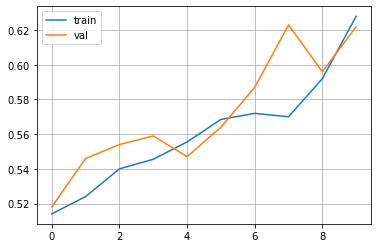

In [14]:
plt.plot(results.history['accuracy'], label=('train'))
plt.plot(results.history['val_accuracy'], label=('val'))
plt.grid(True)
plt.legend()

### Question 3

What is the median of training accuracy for this model?

In [15]:
train_median_acc = round(np.median(results.history['accuracy']), 2)
print(f"[ANSWER-3] The median of training accuracy is: {train_median_acc}")

[ANSWER-3] The median of training accuracy is: 0.56


### Question 4

What is the standard deviation of training loss for this model?

In [16]:
train_std_loss = np.std(results.history['loss'])
print(f"[ANSWER-4] The standard deviation of training loss is: {train_std_loss}")

[ANSWER-4] The standard deviation of training loss is: 0.014680980486043278


### Data Augmentation

For the next two questions, we'll generate more data using data augmentations. 

Add the following augmentations to your training data generator:

* `rotation_range=40,`
* `width_shift_range=0.2,`
* `height_shift_range=0.2,`
* `shear_range=0.2,`
* `zoom_range=0.2,`
* `horizontal_flip=True,`
* `fill_mode='nearest'`

In [17]:
# train dataset generation
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_ds = train_gen.flow_from_directory(
    'dataset/train',
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary',
    shuffle=True
)

Found 20000 images belonging to 2 classes.


### Question 5 

Let's train our model for 10 more epochs using the same code as previously.
Make sure you don't re-create the model - we want to continue training the model
we already started training.

What is the mean of validation loss for the model trained with augmentations?


In [18]:
results_2 = model.fit(train_ds, steps_per_epoch=100, epochs=10, validation_data=val_ds, validation_steps=50)

Epoch 1/10
100/100 [==============================] - 14s 145ms/step - loss: 0.6710 - accuracy: 0.5940 - val_loss: 0.6665 - val_accuracy: 0.5830
Epoch 2/10
100/100 [==============================] - 15s 152ms/step - loss: 0.6800 - accuracy: 0.5715 - val_loss: 0.6572 - val_accuracy: 0.6140
Epoch 3/10
100/100 [==============================] - 17s 174ms/step - loss: 0.6711 - accuracy: 0.5850 - val_loss: 0.6588 - val_accuracy: 0.5910
Epoch 4/10
100/100 [==============================] - 19s 186ms/step - loss: 0.6686 - accuracy: 0.5730 - val_loss: 0.6451 - val_accuracy: 0.6200
Epoch 5/10
100/100 [==============================] - 15s 147ms/step - loss: 0.6653 - accuracy: 0.5935 - val_loss: 0.6372 - val_accuracy: 0.6270
Epoch 6/10
100/100 [==============================] - 16s 160ms/step - loss: 0.6693 - accuracy: 0.5825 - val_loss: 0.6479 - val_accuracy: 0.6240
Epoch 7/10
100/100 [==============================] - 21s 213ms/step - loss: 0.6633 - accuracy: 0.6000 - val_loss: 0.6737 - val_ac

In [24]:
val_mean_loss = np.mean(results_2.history['val_loss'])
print(f"[ANSWER-5] The mean of validation loss  loss is: {val_mean_loss}")

[ANSWER-5] The mean of validation loss  loss is: 0.653546953201294


### Question 6

What's the average of validation accuracy for the last 5 epochs (from 6 to 10)
for the model trained with augmentations?

In [27]:
val_mean_acc = np.average(results_2.history['val_accuracy'][5:])
print(f"[ANSWER-6] The mean of validation accuracy is: {val_mean_acc}")

[ANSWER-6] The mean of validation accuracy is: 0.6091999888420105
